# Classifying trialwise CorrectGo and NoGo trials

There are a number of steps to this. Hopefully we can recycle previous code and be up fairly quickly!

1. Load beta data. Ideally this process should include a cache into a pure python object so we don't have to reload it each time.
2. Preprocess the data.
3. Do cross-validated training and testing. Ideally an inner loop to select best parameters, an outer loop to get cross-validated performance, and final training over all the data to get an image. The inner loop can be probably be handled within the package we use probably.

In [1]:
import socket
import yaml
hostname=socket.gethostname()
hostname='zzz'
with open('sst_config.yml', "r") as f:
    test_config= yaml.safe_load(f)#[hostname]

In [2]:
import sys
import os
import pandas as pd
import numpy as np



sys.path.append(os.path.abspath("../../ml/"))
from apply_loocv_and_save import load_and_preprocess, load_and_preprocess_Brain_Data
from dev_utils import read_yaml_for_host
from dev_utils import get_2DX_from_4DX
import warnings


config_data = read_yaml_for_host("sst_config.yml")



python initialized for apply_loocv_and_save
cpus available; cpus to use:
10 9
10


In [3]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
#I'll add the feature selection step for the estimators here for now,
#but to save time we could add separate functions for preprocessing
#advantage of doing it independently from estimators would be to avoid running feature selection twice.
#disadvantage would be that we'd have to pass the feature

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn import decomposition
#I'll add the feature selection step for the estimators here for now,
#but to save time we could add separate functions for preprocessing
#advantage of doing it independently from estimators would be to avoid running feature selection twice.
#disadvantage would be that we'd have to pass the feature

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif


In [4]:
import multiprocessing
import math
import nibabel as nib
import nilearn as nl
from nilearn.decoding import DecoderRegressor,Decoder
from sklearn.model_selection import KFold,GroupKFold,LeaveOneOut
cpus_available = multiprocessing.cpu_count()

cpus_to_use = min(cpus_available-1,math.floor(0.9*cpus_available))
print(cpus_to_use)

9


In [5]:
from dev_wtp_io_utils import cv_train_test_sets, asizeof_fmt
from dev_utils import sklearn_nested_cross_validate
from nilearn.decoding import DecoderRegressor,Decoder

In [6]:
nonbids_data_path = config_data['nonbids_data_path']
ml_data_folderpath = nonbids_data_path + "fMRI/ml"


## Set up the paradigm

In [7]:

def trialtype_resp_trans_func(X):
    return(X.trial_type)


## Loading beta data

beta data is generally written in `load_multisubject_brain_data_sst_w1.ipynb`.

We just have to load it.

In [8]:
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_betaseries_30subs_correct_cond_pfc.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_betaseries_6subs_correct_cond.pkl'
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_betaseries_nos_6subs_correct_cond_pfc.pkl'

warnings.warn("not sure if this file holds up--it was created in 2021; need to see if it's still valid")
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20220818T144138.csv"

/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_53863/1833047562.py:5: UserWarning: not sure if this file holds up--it was created in 2021; need to see if it's still valid
  warnings.warn("not sure if this file holds up--it was created in 2021; need to see if it's still valid")


In [9]:


all_subjects = load_and_preprocess_Brain_Data(
    brain_data_filepath,
    train_test_markers_filepath,
    #subjs_to_use = None,
    response_transform_func = trialtype_resp_trans_func
    #clean=None
    )

warnings.warn("the data hasn't been cleaned at any point. the fMRIPrep cleaning pipeline has been applied; nothing else has been.")


checked for intersection and no intersection between the brain data and the subjects was found.
there were 6 subjects overlapping between the subjects marked for train data and the training dump file itself.


/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


test_train_set: 62918
brain_data_filepath: 176
pkl_file: 168
train_test_markers_filepath: 158
response_transform_func: 144
Brain_Data_allsubs: 48
634
634


/Users/benjaminsmith/Google Drive/oregon/code/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None
/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_53863/878541407.py:9: UserWarning: the data hasn't been cleaned at any point. the fMRIPrep cleaning pipeline has been applied; nothing else has been.
  warnings.warn("the data hasn't been cleaned at any point. the fMRIPrep cleaning pipeline has been applied; nothing else has been.")


In [10]:
type(all_subjects)



nltools.data.brain_data.Brain_Data

In [11]:
from sklearn.feature_selection import SelectPercentile,f_classif

#convert the y array to an integer array representing the string values of the y array
all_subjects_y_cat = all_subjects.Y.astype('category')
all_subjects_y_int=all_subjects_y_cat.cat.codes

In [12]:
mask_nifti = nib.load(ml_data_folderpath + '/prefrontal_cortex.nii.gz')

In [13]:


num_subjs = 6
if num_subjs < len(all_subjects.X['subject'].unique()):
    #select subjs
    subjs = all_subjects.X['subject'].unique()
    subjs.sort()
    selected_sub_ids=subjs[0:num_subjs]
    selected_rows = all_subjects.X['subject'].isin(selected_sub_ids)
    selected_subjs = all_subjects[selected_rows]
    selected_subjs_y_int = all_subjects_y_int[selected_rows]
else:
    selected_subjs = all_subjects
    selected_subjs_y_int = all_subjects_y_int

In [14]:
#check whether every subject has some of each trial type
trial_types = selected_subjs.Y.unique()
for subj in selected_subjs.X.subject.unique():
    print(subj)
    for trial_type in trial_types:
        print(trial_type)
        print(selected_subjs.X[(selected_subjs.X.subject == subj) & (selected_subjs.Y == trial_type)].shape[0])

DEV011
correct-go
93
correct-stop
15
DEV020
correct-go
96
correct-stop
16
DEV047
correct-go
96
correct-stop
17
DEV063
correct-go
95
correct-stop
12
DEV064
correct-go
96
correct-stop
16
DEV067
correct-go
60
correct-stop
22


/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


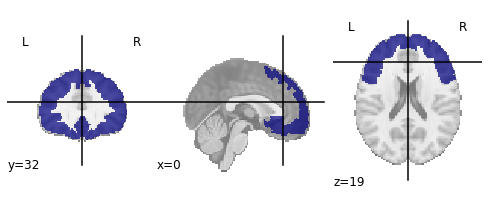

In [15]:
#visualize the mask that has alreayd been applied
nl.plotting.plot_roi(
selected_subjs.mask)

Looks good! I don't think we need to re-mask. But if we needed to, we could probably use apply_maks, right?

In [16]:
# # get the PFC mask
# mask_nifti = nib.load(ml_data_folderpath + '/prefrontal_cortex.nii.gz')
# selected_subjs_masked = selected_subjs.apply_mask(mask_nifti)
# nl.plotting.plot_roi(
#selected_subjs.mask)


The above code took 80 seconds just on a 6-subject dataset. And the mask that was printed looks identical to the previous one. And it seems to have somehow widened the field of view rather than narrowed it. So if we alredy have a pfc-masked dataset, we can skip this.

Transform our mask into the same space as the data


# Training

I'm going to start with `cv_train_test_sets` and see how that goes. It sems likely it'll have to be re-written somewhat, but it might be a good starting point.

I think I need to run this without all the extra scaffolding--just tresting the Decoder on the data until I get something sensible. At the very least we need to know the Decoder object is handling balanced classes correctly.

In [17]:
# use add PFC mask.ipynb to figure out how to get a PFC mask onto this data.

In [18]:
#import SVC
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, SequentialFeatureSelector, SelectKBest


## Other attempts at feature selection

OK, this should make us really sceptical there is good data here. The fact that the overfit score is high shows that on some shallow level, the classification is working--it just isn't picking up signal. It might be worth adding a PCA I suppose.

In [27]:
inner_folds = 3
outer_folds = 3
sample_size_with_cv = (inner_folds-1)/inner_folds * (outer_folds-1)/outer_folds * selected_subjs.data.shape[0]
print(sample_size_with_cv)
for decomp_prop in [2,4,8,16,32]:#[4,16,64,256]:
    
    #decomp_components = (int)(selected_subjs.data.shape[1]/decomp_prop)
    decomp_components = (int)(min(sample_size_with_cv, selected_subjs.data.shape[1])/decomp_prop)
    print(str(decomp_components) + ' components')

    # pca_decomp = decomposition.PCA(n_components=decomp_components)
    # pca_decomp.fit(selected_subjs.data)

    # data_pca = pca_decomp.transform(selected_subjs.data)
    print('success!')

281.77777777777777
140 components
success!
70 components
success!
35 components
success!
17 components
success!
8 components
success!


In [32]:


estimators = [
    # LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced'),
    # LogisticRegression(penalty='l2',solver='liblinear',class_weight='balanced'),
    RidgeClassifierCV(class_weight='balanced')
]
estimators_with_fs = []
#now wrap the estimators in a pipeline that does feature selection
inner_folds = 3
outer_folds = 3
sample_size_with_cv = (inner_folds-1)/inner_folds * (outer_folds-1)/outer_folds * selected_subjs.data.shape[0]
print(sample_size_with_cv)

for estimator in estimators:
    for decomp_prop in [2,4,8,16,32]:#[4,16,64,256]:
        #decomp_components = (int)(selected_subjs.data.shape[1]/decomp_prop)
        decomp_components = (int)(min(sample_size_with_cv, selected_subjs.data.shape[1])/decomp_prop)
        print(str(decomp_components) + ' components')

        estimator_with_fs = Pipeline([
            ('clean',VarianceThreshold(threshold=0)),
            ('decompose', decomposition.PCA(n_components=decomp_components)),
            #('select', SelectKBest(f_classif, k=150)),
            ('estimator', estimator)])
        estimators_with_fs.append(estimator_with_fs)


    estimator_with_fs = Pipeline([
        ('clean',VarianceThreshold(threshold=0)),
        #('select', SelectKBest(f_classif, k=150)),
        ('estimator', estimator)])
    estimators_with_fs.append(estimator_with_fs)

    estimator_with_fs = Pipeline([
        ('clean',VarianceThreshold(threshold=0)),
        ('select', SelectKBest(f_classif, k=150)),
        ('estimator', estimator)])
    estimators_with_fs.append(estimator_with_fs)


    
#from dev_utils import sklearn_nested_cross_validate

cv_result = sklearn_nested_cross_validate(
    selected_subjs.data,
    np.array(selected_subjs_y_int),
    estimators_with_fs,
    groups=np.array(selected_subjs.X['subject']))
        
   

from sklearn.metrics import roc_auc_score


pd.Series(cv_result['y_predict_final']).value_counts()
roc_auc_score(selected_subjs_y_int,cv_result['y_predict_final'])

281.77777777777777
140 components
70 components
35 components
17 components
8 components
generalization test group 0
439
195
hyper-parameter search group 0
327
112
estimating...estimator 0; ROC AUC score: 0.5
estimating...estimator 1; ROC AUC score: 0.5
estimating...estimator 2; ROC AUC score: 0.515625
estimating...estimator 3; ROC AUC score: 0.4791666666666667
estimating...estimator 4; ROC AUC score: 0.484375
estimating...estimator 5; ROC AUC score: 0.4635416666666667
estimating...estimator 6; ROC AUC score: 0.453125
hyper-parameter search group 1
327
112
estimating...estimator 0; ROC AUC score: 0.4947916666666667
estimating...estimator 1; ROC AUC score: 0.5
estimating...estimator 2; ROC AUC score: 0.4791666666666667
estimating...estimator 3; ROC AUC score: 0.5052083333333334
estimating...estimator 4; ROC AUC score: 0.46875
estimating...estimator 5; ROC AUC score: 0.53125
estimating...estimator 6; ROC AUC score: 0.5677083333333334
hyper-parameter search group 2
224
215
estimating...es

0.49506929637526653

In [33]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

#I'll add the feature selection step for the estimators here for now,
#but to save time we could add separate functions for preprocessing
#advantage of doing it independently from estimators would be to avoid running feature selection twice.
#disadvantage would be that we'd have to pass the feature

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

estimators = [
    LinearSVC(penalty='l2',max_iter=1e6,class_weight='balanced'),
    LogisticRegression(penalty='l2',solver='liblinear',class_weight='balanced')

]
estimators_with_fs = []
#now wrap the estimators in a pipeline that does feature selection
for estimator in estimators:
    estimator_with_fs = Pipeline([
        ('clean',VarianceThreshold(threshold=0)),
        ('select', SelectKBest(f_classif, k=200)),
        ('estimator', estimator)])
    estimators_with_fs.append(estimator_with_fs)

    
from dev_utils import sklearn_nested_cross_validate

cv_result = sklearn_nested_cross_validate(
    selected_subjs.data,
    np.array(selected_subjs_y_int),
    estimators_with_fs,
    groups=np.array(selected_subjs.X['subject']))
        
   

from sklearn.metrics import roc_auc_score


pd.Series(cv_result['y_predict_final']).value_counts()
roc_auc_score(selected_subjs_y_int,cv_result['y_predict_final'])

generalization test group 0
439
195
hyper-parameter search group 0
327
112
estimating...estimator 0; ROC AUC score: 0.59375
estimating...estimator 1; ROC AUC score: 0.6041666666666666
hyper-parameter search group 1
327
112
estimating...estimator 0; ROC AUC score: 0.5833333333333334
estimating...estimator 1; ROC AUC score: 0.6458333333333334
hyper-parameter search group 2
224
215
estimating...estimator 0; ROC AUC score: 0.5171394799054374
estimating...estimator 1; ROC AUC score: 0.5356579984239558
generalization test group 1
414
220
hyper-parameter search group 0
301
113
estimating...estimator 0; ROC AUC score: 0.4387254901960784
estimating...estimator 1; ROC AUC score: 0.4439338235294118
hyper-parameter search group 1
302
112
estimating...estimator 0; ROC AUC score: 0.6041666666666666
estimating...estimator 1; ROC AUC score: 0.578125
hyper-parameter search group 2
225
189
estimating...estimator 0; ROC AUC score: 0.43671726755218215
estimating...estimator 1; ROC AUC score: 0.40265654648

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


generalization test group 1


/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


generalization test group 2
cross-validated score is: 0.5632614986293024
precision, recall, fscore, support:
(array([0.87572254, 0.19097222]), array([0.56529851, 0.56122449]), array([0.68707483, 0.28497409]), array([536,  98]))
raw (overfit) score is: 0.7888745050258911


/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.5632614986293024

In [34]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

#I'll add the feature selection step for the estimators here for now,
#but to save time we could add separate functions for preprocessing
#advantage of doing it independently from estimators would be to avoid running feature selection twice.
#disadvantage would be that we'd have to pass the feature

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

estimators = [
    LogisticRegression(penalty='l2',solver='liblinear',class_weight='balanced')

]
estimators_with_fs = []
#now wrap the estimators in a pipeline that does feature selection
for estimator in estimators:
    estimator_with_fs = Pipeline([
        ('clean',VarianceThreshold(threshold=0)),
        ('select', SelectKBest(f_classif, k=200)),
        ('estimator', estimator)])
    estimators_with_fs.append(estimator_with_fs)

    
from dev_utils import sklearn_nested_cross_validate

cv_result = sklearn_nested_cross_validate(
    selected_subjs.data,
    np.array(selected_subjs_y_int),
    estimators_with_fs,
    groups=np.array(selected_subjs.X['subject']))
        
   

from sklearn.metrics import roc_auc_score


pd.Series(cv_result['y_predict_final']).value_counts()
roc_auc_score(selected_subjs_y_int,cv_result['y_predict_final'])

generalization test group 0
439
195
hyper-parameter search group 0
327
112
estimating...estimator 0; ROC AUC score: 0.6041666666666666
hyper-parameter search group 1
327
112
estimating...estimator 0; ROC AUC score: 0.6458333333333334
hyper-parameter search group 2
224
215
estimating...estimator 0; ROC AUC score: 0.5356579984239558
generalization test group 1
414
220
hyper-parameter search group 0
301
113
estimating...estimator 0; ROC AUC score: 0.4439338235294118
hyper-parameter search group 1
302
112
estimating...estimator 0; ROC AUC score: 0.578125
hyper-parameter search group 2
225
189
estimating...estimator 0; ROC AUC score: 0.4026565464895635
generalization test group 2
415
219
hyper-parameter search group 0
302
113
estimating...estimator 0; ROC AUC score: 0.47273284313725494
hyper-parameter search group 1
303
112
estimating...estimator 0; ROC AUC score: 0.4322916666666667
hyper-parameter search group 2
225
190
estimating...estimator 0; ROC AUC score: 0.544338456103162
estimator_i

0.5432911970758453

In [35]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

#I'll add the feature selection step for the estimators here for now,
#but to save time we could add separate functions for preprocessing
#advantage of doing it independently from estimators would be to avoid running feature selection twice.
#disadvantage would be that we'd have to pass the feature

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

estimators = [
    LogisticRegression(penalty='l2',solver='liblinear',class_weight='balanced')

]
estimators_with_fs = []


for estimator in estimators:
    for decomp_prop in [2,4,8,16,32]:#[4,16,64,256]:
        #decomp_components = (int)(selected_subjs.data.shape[1]/decomp_prop)
        decomp_components = (int)(min(sample_size_with_cv, selected_subjs.data.shape[1])/decomp_prop)
        print(str(decomp_components) + ' components')

        estimator_with_fs = Pipeline([
            ('clean',VarianceThreshold(threshold=0)),
            ('decompose', decomposition.PCA(n_components=decomp_components)),
            #('select', SelectKBest(f_classif, k=150)),
            ('estimator', estimator)])
        estimators_with_fs.append(estimator_with_fs)

    estimator_with_fs = Pipeline([
        ('clean',VarianceThreshold(threshold=0)),
        ('select', SelectKBest(f_classif, k=150)),
        ('estimator', estimator)])
    estimators_with_fs.append(estimator_with_fs)
    
    
from dev_utils import sklearn_nested_cross_validate

cv_result = sklearn_nested_cross_validate(
    selected_subjs.data,
    np.array(selected_subjs_y_int),
    estimators_with_fs,
    groups=np.array(selected_subjs.X['subject']))
        
   

from sklearn.metrics import roc_auc_score


pd.Series(cv_result['y_predict_final']).value_counts()
roc_auc_score(selected_subjs_y_int,cv_result['y_predict_final'])

140 components
70 components
35 components
17 components
8 components
generalization test group 0
439
195
hyper-parameter search group 0
327
112
estimating...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


estimator 0; ROC AUC score: 0.515625
estimating...estimator 1; ROC AUC score: 0.4895833333333333
estimating...estimator 2; ROC AUC score: 0.5
estimating...estimator 3; ROC AUC score: 0.5260416666666667
estimating...estimator 4; ROC AUC score: 0.4583333333333333
estimating...estimator 5; ROC AUC score: 0.359375
hyper-parameter search group 1
327
112
estimating...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


estimator 0; ROC AUC score: 0.4479166666666667
estimating...estimator 1; ROC AUC score: 0.5
estimating...estimator 2; ROC AUC score: 0.484375
estimating...estimator 3; ROC AUC score: 0.38541666666666663
estimating...estimator 4; ROC AUC score: 0.42708333333333337
estimating...estimator 5; ROC AUC score: 0.5260416666666667
hyper-parameter search group 2
224
215
estimating...estimator 0; ROC AUC score: 0.5339834515366431
estimating...estimator 1; ROC AUC score: 0.505220646178093
estimating...estimator 2; ROC AUC score: 0.5025610717100079
estimating...estimator 3; ROC AUC score: 0.49990149724192273
estimating...estimator 4; ROC AUC score: 0.5131993695823482
estimating...estimator 5; ROC AUC score: 0.45360520094562645
generalization test group 1
414
220
hyper-parameter search group 0
301
113
estimating...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


estimator 0; ROC AUC score: 0.5689338235294118
estimating...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


estimator 1; ROC AUC score: 0.4822303921568628
estimating...estimator 2; ROC AUC score: 0.4895833333333333
estimating...estimator 3; ROC AUC score: 0.4822303921568628
estimating...estimator 4; ROC AUC score: 0.49264705882352944
estimating...estimator 5; ROC AUC score: 0.4696691176470589
hyper-parameter search group 1
302
112
estimating...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


estimator 0; ROC AUC score: 0.5416666666666666
estimating...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


estimator 1; ROC AUC score: 0.5260416666666666
estimating...estimator 2; ROC AUC score: 0.4895833333333333
estimating...estimator 3; ROC AUC score: 0.59375
estimating...estimator 4; ROC AUC score: 0.59375
estimating...estimator 5; ROC AUC score: 0.5052083333333334
hyper-parameter search group 2
225
189
estimating...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


estimator 0; ROC AUC score: 0.568595825426945
estimating...estimator 1; ROC AUC score: 0.5789373814041746
estimating...estimator 2; ROC AUC score: 0.5624288425047438
estimating...estimator 3; ROC AUC score: 0.5706831119544592
estimating...estimator 4; ROC AUC score: 0.5132827324478179
estimating...estimator 5; ROC AUC score: 0.4679316888045541
generalization test group 2
415
219
hyper-parameter search group 0
302
113
estimating...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


estimator 0; ROC AUC score: 0.4788602941176471
estimating...estimator 1; ROC AUC score: 0.484375
estimating...estimator 2; ROC AUC score: 0.5033700980392157
estimating...estimator 3; ROC AUC score: 0.529718137254902
estimating...estimator 4; ROC AUC score: 0.49295343137254904
estimating...estimator 5; ROC AUC score: 0.4935661764705883
hyper-parameter search group 1
303
112
estimating...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


estimator 0; ROC AUC score: 0.45833333333333337
estimating...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


estimator 1; ROC AUC score: 0.453125
estimating...estimator 2; ROC AUC score: 0.5
estimating...estimator 3; ROC AUC score: 0.578125
estimating...estimator 4; ROC AUC score: 0.5052083333333333
estimating...estimator 5; ROC AUC score: 0.4375
hyper-parameter search group 2
225
190
estimating...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


estimator 0; ROC AUC score: 0.47915562621444974
estimating...estimator 1; ROC AUC score: 0.5074191838897721
estimating...estimator 2; ROC AUC score: 0.5069775658010952
estimating...estimator 3; ROC AUC score: 0.5399222752163928
estimating...estimator 4; ROC AUC score: 0.5004416180886769
estimating...estimator 5; ROC AUC score: 0.5591768238827062
estimator_i
3    0.522865
0    0.510341
2     0.50432
1    0.502993
4    0.499655
5    0.474675
Name: score, dtype: Float64
chose estimator 3
generalization test group 0
generalization test group 1
generalization test group 2
cross-validated score is: 0.4820667072799269
precision, recall, fscore, support:
(array([0.83707865, 0.14388489]), array([0.55597015, 0.40816327]), array([0.66816143, 0.21276596]), array([536,  98]))
raw (overfit) score is: 0.6153289674078587


0.4820667072799269

In [36]:
#do a wilcox test (Mann-Whitney U test) to see if the difference in AUC significantly differs from 0.5
#include a confidence interval
from scipy.stats import wilcoxon
wilcoxon(cv_result['y_predict_final'],selected_subjs_y_int)

WilcoxonResult(statistic=8613.0, pvalue=1.287101945119916e-25)